# Introduction

Put something here

# Imports and setup

In [1]:
# importing, reading, and combining data
import numpy as np 
import pandas as pd

# sklearn for classifiers and testing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# data balancing
import collections
from imblearn.over_sampling import SMOTE

# figures and visualization
import matplotlib.ticker as mticker
import plotly.express as px
import seaborn as sn
import matplotlib.pyplot as plt

# misc
import time

# maps
import geopandas as gpd

In [2]:
# get source data
source_directory = "E:\Git_repos\Australian_rain/"
source_table = "E:\Git_repos\Australian_rain\weatherAUS.csv"
shapefile = "E:\Git_repos\Australian_rain\states\STE_2016_AUST.shp"
source_df = pd.read_csv(source_table)

# explore dataset
source_df.head(10)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
5  2008-12-06   Albury     14.6     29.7       0.2          NaN       NaN   
6  2008-12-07   Albury     14.3     25.0       0.0          NaN       NaN   
7  2008-12-08   Albury      7.7     26.7       0.0          NaN       NaN   
8  2008-12-09   Albury      9.7     31.9       0.0          NaN       NaN   
9  2008-12-10   Albury     13.1     30.1       1.4          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   
5         WNW           56.0          W  ...        55.0         23.0   
6           W           50.0         SW  ...        49.0         19.0   
7           W           35.0        SSE  ...        48.0         19.0   
8         NNW           80.0         SE  ...        42.0          9.0   
9           W           28.0          S  ...        58.0         27.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   
5       1009.2       1005.4       NaN       NaN     20.6     28.9         No   
6       1009.6       1008.2       1.0       NaN     18.1     24.6         No   
7       1013.4       1010.1       NaN       NaN     16.3     25.5         No   
8       1008.9       1003.6       NaN       NaN     18.3     30.2         No   
9       1007.0       1005.7       NaN       NaN     20.1     28.2        Yes   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  
5            No  
6            No  
7            No  
8           Yes  
9            No  

[10 rows x 23 columns]

# Raw data exploration

This dataset contains a lot of really cool weather data that's fun to play around with in its own right. 

## Temperature data

Let's examine some of the cyclical changes in temperature across Australia.

In [3]:
print(pd.to_datetime("2007-11-01"))

2007-11-01 00:00:00


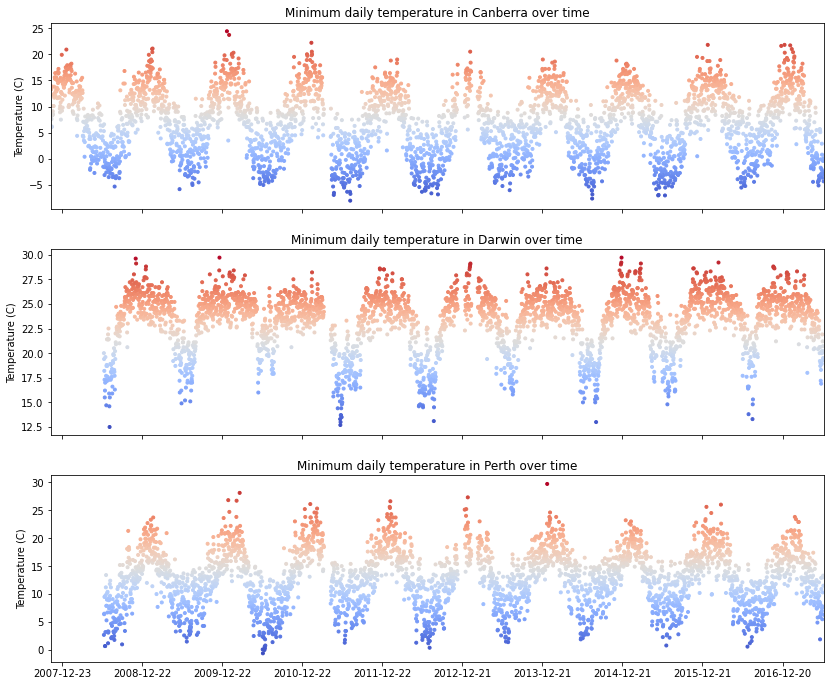

In [4]:
# set up time series figure
fig, ax = plt.subplots(3, figsize=(12, 10), sharex=True);

# add some padding
fig.tight_layout(pad=3.0)

# set a list of cities to examine
city_list = ["Canberra", "Darwin", "Perth"]

# get x axis range from the city list
city_df = source_df[source_df["Location"].isin(city_list)]
x_min = min(pd.to_datetime(city_df["Date"]))
x_max = max(pd.to_datetime(city_df["Date"]))


# make a function to generate some scatter plots
def plot_minimum_temperature(station, index):
    
    # mask out a station of interest
    station_id = station
    station = source_df[source_df["Location"] == station_id] 
    min_temp = station["MinTemp"]

    # plot the time series
    ax[index].scatter(pd.to_datetime(station["Date"]), min_temp, 
               c=station["MinTemp"], marker=".", 
               cmap="coolwarm");

    # set titles, labels; remove axes
    ax[index].set_title("Minimum daily temperature in {} over time".format(station_id))
    ax[index].set_ylabel("Temperature (C)")
    
    # set ticks to be every year (365 days)
    yearLocator = mticker.MultipleLocator(365)
    ax[index].xaxis.set_major_locator(yearLocator)
    
    # set the min and max limits to be the same on each subplot
    ax[index].set_xlim([x_min, x_max])
    
# plot some station data
for city, index in zip(city_list, range(0, len(city_list)+1)):
    plot_minimum_temperature(city, index)

Note that the temperatures in Darwin (nearer to the equator) are much hotter in the summer and winter, and that the summers in Darwin are also much longer. Canberra has realtively cold winters, but the lengths of the seasons match Perth as they are near the same latitude.

### Wind data

Since we have wind direction data it's only natural that we should make a rose diagram too!

In [5]:
# make out the station of interest
wind_df = source_df[source_df["Location"] == "Canberra"]

# get the wind directions as frequencies
wind_df = wind_df.groupby(["WindGustDir"]).size().reset_index(name="frequency")

# put the values in cardinal directions
cardinal_order = ["N", "NNE", "NE", "ENE", 
                  "E", "ESE", "SE", "SSE", 
                  "S", "SSW", "SW", "WSW", 
                  "W", "WNW", "NW", "NNW"]

# set the direction as the index
wind_df = wind_df.set_index(wind_df["WindGustDir"])

# reorder it based on the correct direction
wind_df = wind_df.reindex(cardinal_order)

# generate a rose diagram
fig = px.bar_polar(wind_df, r="frequency", theta="WindGustDir",
                   color="frequency", template="simple_white",
                   color_discrete_sequence= px.colors.sequential.haline)

# add a title and legend
fig.update_layout(
    title='Wind Speed Distribution in Canberra, Australia',
    font_size=12,
    legend_font_size=12,
    polar_angularaxis_rotation=90)
  
# show the figure
fig.show()

Seems to be have a very strong NW signal, and a smaller E component.

# Data preparation

We need to massage our data for the algorithms, and also to enable later analysis. Here we'll assign each station to the state it's in, and change our categorical data with numerical substitutes. We also need to elimate records where NaN values cannot be determined, and fill NaN values where we can.

In [6]:
# make territory dictionary (ew manual work)
territory_dict = {"New South Wales": ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 
                          'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 
                          'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong'],
                  "Victoria": ['Ballarat', 'Bendigo', 'Dartmoor', 'Sale', 'MelbourneAirport', 'Melbourne','Mildura',
                          'Nhil', 'Portland', 'Watsonia'],
                  "Queensland": ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'],
                  "South Australia": ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'],
                  "Western Australia": ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums'
                          'Walpole'],
                  "Tasmania": ['Hobart', 'Launceston'],
                  "Northern Territories": ['AliceSprings', 'Darwin', 'Katherine', 'Uluru'],
                  "Australian Capital Territory": ['Canberra', 'Tuggeranong', 'Mount Ginini'], }

# replace categorical values
cardinal_dict = {"N": 0, "NNE": 1, "NE": 2, "ENE": 3,
                 "E": 4, "ESE": 5, "SE": 6, "SSE": 7,
                 "S": 8, "SSW": 9, "SW": 10, "WSW": 11,
                 "W": 12, "WNW": 13, "NW": 14, "NNW": 15}


# substitute the cardinal directions wherever they occur
categorical_replacements = {"WindGustDir": cardinal_dict,
                            "WindDir9am": cardinal_dict,
                            "WindDir3pm": cardinal_dict,
                            "RainToday": {"No":0, "Yes": 1},
                            "RainTomorrow": {"No":0, "Yes": 1}}

# convert the categorical data
source_df = source_df.replace(categorical_replacements)

# drop columns that are mostly NaN right away.
source_df.drop(columns=['Evaporation', 'Sunshine', "Cloud9am", "Cloud3pm"])

# drop any row with a NaN
source_df = source_df.dropna(axis=0)

# check the header now
source_df.head(10)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
6049  2009-01-01    Cobar     17.9     35.2       0.0         12.0      12.3   
6050  2009-01-02    Cobar     18.4     28.9       0.0         14.8      13.0   
6052  2009-01-04    Cobar     19.4     37.6       0.0         10.8      10.6   
6053  2009-01-05    Cobar     21.9     38.4       0.0         11.4      12.2   
6054  2009-01-06    Cobar     24.2     41.0       0.0         11.2       8.4   
6055  2009-01-07    Cobar     27.1     36.1       0.0         13.0       0.0   
6056  2009-01-08    Cobar     23.3     34.0       0.0          9.8      12.6   
6057  2009-01-09    Cobar     16.1     34.2       0.0         14.6      13.2   
6058  2009-01-10    Cobar     19.0     35.5       0.0         12.0      12.3   
6059  2009-01-11    Cobar     19.7     35.5       0.0         11.0      12.7   

      WindGustDir  WindGustSpeed  WindDir9am  ...  Humidity9am  Humidity3pm  \
6049          9.0           48.0         3.0  ...         20.0         13.0   
6050          8.0           37.0         7.0  ...         30.0          8.0   
6052          1.0           46.0         1.0  ...         42.0         22.0   
6053         13.0           31.0        13.0  ...         37.0         22.0   
6054         13.0           35.0        14.0  ...         19.0         15.0   
6055          0.0           43.0         0.0  ...         26.0         19.0   
6056          9.0           41.0         8.0  ...         33.0         15.0   
6057          6.0           37.0         6.0  ...         25.0          9.0   
6058          3.0           48.0         3.0  ...         46.0         28.0   
6059          2.0           41.0         1.0  ...         61.0         14.0   

      Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
6049       1006.3       1004.4       2.0       5.0     26.6     33.4   
6050       1012.9       1012.1       1.0       1.0     20.3     27.0   
6052       1012.3       1009.2       1.0       6.0     28.7     34.9   
6053       1012.7       1009.1       1.0       5.0     29.1     35.6   
6054       1010.7       1007.4       1.0       6.0     33.6     37.6   
6055       1007.7       1007.4       8.0       8.0     30.7     34.3   
6056       1011.3       1009.9       3.0       1.0     25.0     31.5   
6057       1013.3       1009.2       1.0       1.0     20.7     32.8   
6058       1008.3       1004.0       1.0       5.0     23.4     33.3   
6059       1007.9       1005.8       1.0       5.0     24.0     33.6   

      RainToday  RainTomorrow  
6049        0.0           0.0  
6050        0.0           0.0  
6052        0.0           0.0  
6053        0.0           0.0  
6054        0.0           0.0  
6055        0.0           0.0  
6056        0.0           0.0  
6057        0.0           0.0  
6058        0.0           0.0  
6059        0.0           0.0  

[10 rows x 23 columns]

## Checking for correlated values

Since we're going to be training some models on these data, we should make sure that we don't have any proxy features that will let the model cheat. Here we'll generate a correlation matrix between all the features. We're most concerned about high correlations between "Rainfall" (measured in mm), "RainToday" (binary yes/no or really 1/0), and "RainTomorrow" (also binary 1/0).

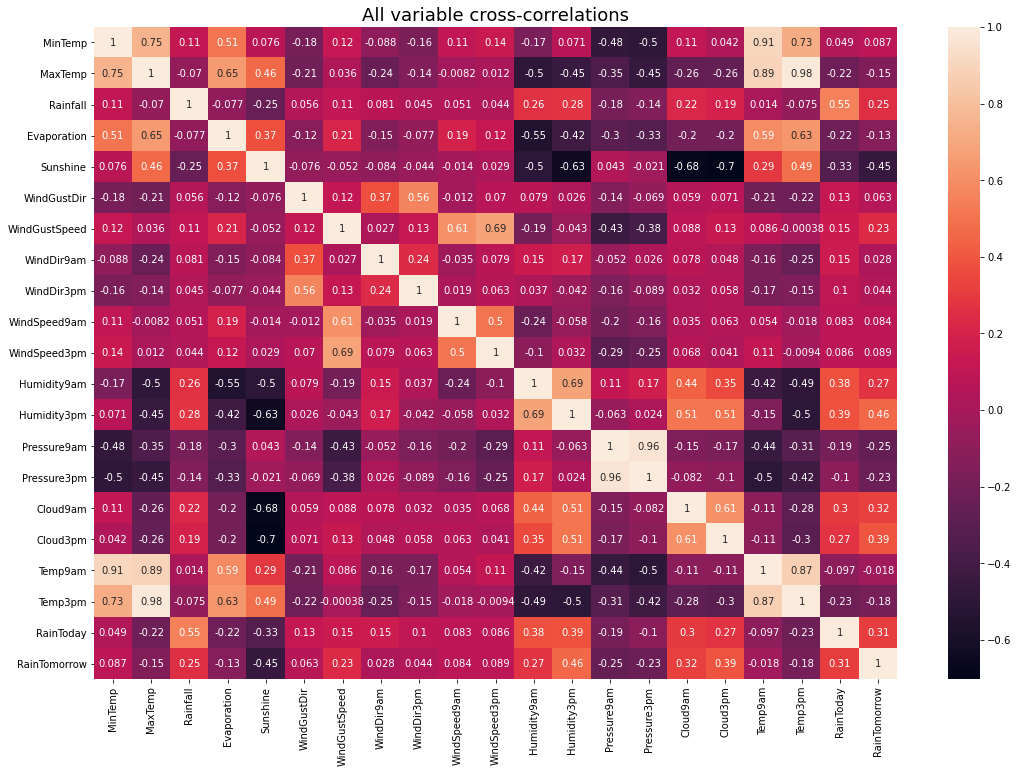

In [7]:
# set up the correlation figure
fig, ax = plt.subplots(1, figsize=(18, 12));

correlation_df = source_df

ax.set_title("All variable cross-correlations", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

corrMatrix = correlation_df.corr()
sn.heatmap(corrMatrix, annot=True ,ax=ax)
plt.show()

"Rainfall" and "RainToday" are correlated (0.5) which is no suprise. We will exlude "Rainfall" when we try to predict "RainToday". Otherwise, the correlations between the other features and and "RainToday" and "RainTomorrow" are very low, which is excellent. This will allow us to demonstrate the efficacy of a complex model like a random forest. 

Next, we'll set up the features and targets for predicting rain tomorrow.

In [8]:
# get a list of features, split into independent and dependent
tomorrow_feature_list = ['MinTemp', 'MaxTemp', 
                         'Rainfall', 'WindGustDir', 
                         'WindGustSpeed', 'WindDir9am', 
                         'WindDir3pm', 'WindSpeed9am', 
                         'WindSpeed3pm', 'Humidity9am', 
                         'Humidity3pm', 'Pressure9am', 
                         'Pressure3pm', 'Temp9am', 
                         'Temp3pm', 'RainToday']
tomorrow_target_list = ['RainTomorrow']

# split
features = source_df.loc[:, tomorrow_feature_list]
target = source_df.loc[:, tomorrow_target_list]

Rain in Australia is pretty rare, so let's check to see if our "RainTomorrow" classes are imbalanced.

In [9]:
# check the balance of the data
count_no_rain = len(target[target["RainTomorrow"] == 0])
count_rain = len(target[target["RainTomorrow"] == 1])
balance = round(count_rain/count_no_rain, 1)
print("The starting balance is: ~{}% 'rain'.".format(100*balance))

The starting balance is: ~30.0% 'rain'.


Let's plot some data and see which values correspond to rain.

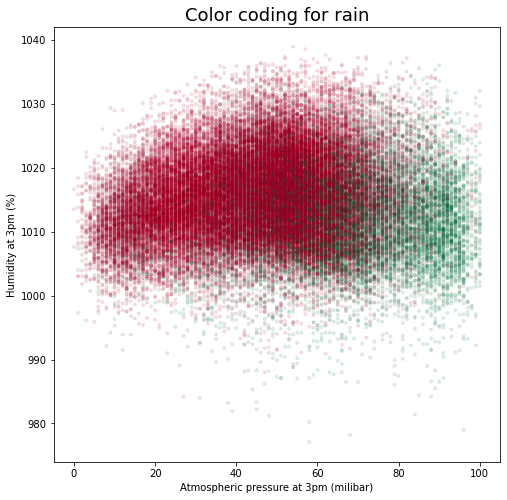

In [10]:
# set up a figure
fig, ax = plt.subplots(1, figsize=(8, 8));

# set the title
ax.set_title("Color coding for rain", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

# plot two variables and color code by our target classes
ax.scatter(features["Humidity3pm"], features["Pressure3pm"], 
            c=target["RainTomorrow"], alpha=0.1, marker='.', cmap='RdYlGn')

# label the axes
ax.set_ylabel("Humidity at 3pm (%)")
ax.set_xlabel("Atmospheric pressure at 3pm (milibar)")

plt.show()

There are way more red values than green values so our data are imbalanced. We can fix that by generating sythetic samples of "rain" in "RainTomorrow" to even things out.

In [11]:
# balance the data via SMOTE
oversample = SMOTE()
features_res, target_res = oversample.fit_resample(features, target)

Now let's compare that same plot.

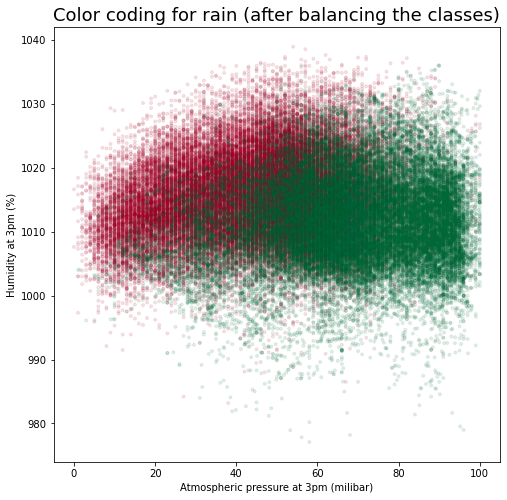

In [12]:
# set up a figure
fig, ax = plt.subplots(1, figsize=(8, 8));

# set the title
ax.set_title("Color coding for rain (after balancing the classes)", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

# plot two variables and color code by our target classes
ax.scatter(features_res["Humidity3pm"], features_res["Pressure3pm"], 
            c=target_res["RainTomorrow"], alpha=0.1, marker='.', cmap='RdYlGn')

# label the axes
ax.set_ylabel("Humidity at 3pm (%)")
ax.set_xlabel("Atmospheric pressure at 3pm (milibar)")

plt.show()

The target classes are much more balanced now.

We next need to scale all the features for the model.

In [13]:
# standardize all the features
features = StandardScaler().fit_transform(features)

We'll reserve 20% of the data as our test sample.

In [14]:
# train test split
feature_train, feature_test, target_train, target_test = train_test_split(features_res, 
                                                                          target_res, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

To optimize our models we'll do a cross-validated grid search. To make things easier, we'll make a function to return the optimal values.

In [15]:
# define a function that performs a grid search
def rain_grid_search(estimator, parameter_grid, train_X, train_y):
  
    # mark the start of the tuning process  
    start_time = time.time()

    # initalize the grid search
    grid_search = GridSearchCV(estimator, parameter_grid, n_jobs=-1)

    # apply the grid search to the training data
    grid_search_application = grid_search.fit(train_X, train_y)

    # mark the end of the tuning process
    end_time = time.time()

    # print the elapsed time
    print("Grid search time: {}".format(round(end_time - start_time, 3)))

    # return the best parameters
    return(grid_search_application.best_params_)

We can now optimize our classifier's hyperparameters.

In [16]:
# tune decision tree's hyperparameters
parameter_grid =  {'criterion': ["gini", "entropy"],
                   'splitter': ["best", "random"],
                   'max_features': ["auto", "sqrt", "log2"],
                   'max_depth': [5, 10, 20, 40, 100, 200],
                   'min_samples_leaf': [1, 2, 4, 6, 8, 10, 100]}

dt_parameters = rain_grid_search(DecisionTreeClassifier(), 
                                 parameter_grid, 
                                 feature_train, 
                                 target_train)

Grid search time: 25.269


Next, we'll write a function to apply our decision tree classifier.

In [17]:
# write a function to apply a decision tree
def apply_decision_tree(train_X, train_y, test_X, test_y):
    
    # mark the start time
    start_time = time.time()

    # initialize the dt model
    dt_model = DecisionTreeClassifier(criterion=dt_parameters['criterion'],
                                      splitter=dt_parameters['splitter'],
                                      max_depth=dt_parameters['max_depth'],
                                      min_samples_leaf=dt_parameters['min_samples_leaf'],
                                      max_features=dt_parameters['max_features'])

    # fit the model to the training data
    dt_model.fit(train_X, train_y)

    # apply the model to the test data
    dt_model_predict = dt_model.predict(test_X)

    # mark the end time
    end_time = time.time()

    # save the time elapsed
    dt_model_time = round(end_time - start_time, 3)

    # get the results
    dt_results = classification_report(test_y, dt_model_predict)
    dt_dict_results = classification_report(test_y, dt_model_predict, output_dict=True)
    
    # print the results and parameters
    print("Time to apply the classifier: " + str(dt_model_time) + "s.")
    
    return dt_dict_results

We'll start by testing a decision tree on the whole of Australia.

In [18]:
# apply a decision tree to the whole country
results = apply_decision_tree(feature_train, target_train, feature_test, target_test);

# print the accuracy
print("Overall accuracy: {}%".format(round(100*results["accuracy"])))

Time to apply the classifier: 0.319s.
Overall accuracy: 83%


An overall accuracy of ~85% is pretty good across the whole country, but let's see if we can't do better if we split the country up by state.

In [19]:
# make a simple dictionary to store results
tomorrow_accuracy_list = []

# loop through each state and apply the same functions as above
for state in territory_dict:
    
    print("State: " + state)
    
    # mask stations not in that state
    state_df = source_df[source_df["Location"].isin(territory_dict[state])]
    
    # split into features and targets
    state_features = state_df.loc[:, tomorrow_feature_list].values
    state_target = state_df.loc[:, tomorrow_target_list].values
    
    # standardize the features by state
    state_features = StandardScaler().fit_transform(state_features)
    
    # balance the state samples
    state_features_res, state_target_res = oversample.fit_resample(state_features, state_target)
    
    # train/test split by state
    state_feature_train, state_feature_test, state_target_train, state_target_test = train_test_split(state_features_res, 
                                                                                                      state_target_res, 
                                                                                                      test_size=0.2, 
                                                                                                      random_state=42)
    
    # tune the decision tree
    dt_parameters = rain_grid_search(DecisionTreeClassifier(), 
                                     parameter_grid, 
                                     state_feature_train, 
                                     state_target_train)
    
    # apply the decision tree
    results = apply_decision_tree(state_feature_train, 
                                  state_target_train, 
                                  state_feature_test, 
                                  state_target_test)

    
    tomorrow_accuracy_list.append(round(results['accuracy'], 3))
    
    print("Accuracy: {}\n".format(round(results['accuracy'], 3)))

State: New South Wales
Grid search time: 4.123
Time to apply the classifier: 0.067s.
Accuracy: 0.817

State: Victoria
Grid search time: 3.82
Time to apply the classifier: 0.062s.
Accuracy: 0.827

State: Queensland
Grid search time: 2.405
Time to apply the classifier: 0.03s.
Accuracy: 0.836

State: South Australia
Grid search time: 2.28
Time to apply the classifier: 0.029s.
Accuracy: 0.849

State: Western Australia
Grid search time: 2.451
Time to apply the classifier: 0.024s.
Accuracy: 0.895

State: Tasmania
Grid search time: 1.391
Time to apply the classifier: 0.008s.
Accuracy: 0.808

State: Northern Territories
Grid search time: 2.033
Time to apply the classifier: 0.023s.
Accuracy: 0.868

State: Australian Capital Territory
Grid search time: 1.279
Time to apply the classifier: 0.005s.
Accuracy: 0.802



This is spatial data, so let's plot it as a map. First we need to get some geographic data.

In [20]:
# get the shapefile
Australia = gpd.read_file(shapefile)

# drop the 'other' states
Australia.drop(Australia.tail(1).index,inplace=True)

# add the accuracy data as a new column
Australia["Tomorrow Accuracy"] = tomorrow_accuracy_list

# generate centroids for each state
Australia['coords'] = Australia['geometry'].apply(lambda x: x.representative_point().coords[:])
Australia['coords'] = [coords[0] for coords in Australia['coords']]

Now we can plot the overall accuracy by state.

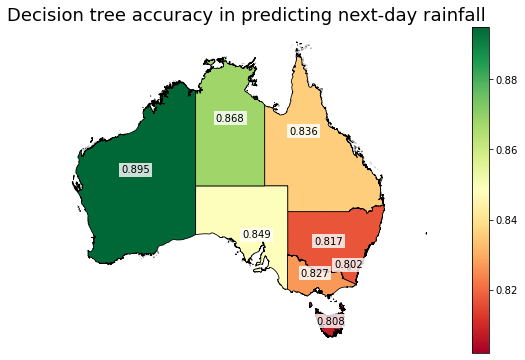

In [21]:
# set up the map figure
fig, ax = plt.subplots(1, figsize=(10, 6));

# set the title
ax.set_title("Decision tree accuracy in predicting next-day rainfall ", fontdict={"fontsize": "18", 
                                                                              "fontweight": "3"})

# plot the accuracy column
Australia.plot(column="Tomorrow Accuracy", linewidth=0.8, ax=ax, edgecolor='0', cmap='RdYlGn');

# annotate the states with their scores
for idx, row in Australia.iterrows():
    ax.text(row.coords[0], row.coords[1], 
            s=row["Tomorrow Accuracy"], 
            horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

# set up the color bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(tomorrow_accuracy_list), 
                                                             vmax=max(tomorrow_accuracy_list)))

# make an empty array for the data range
sm._A = []

# plot the bar
bar = fig.colorbar(sm)

# remove axes from map
ax.axis('off')

plt.savefig(source_directory + "/Figures/Next-day_accuracy.png", dpi=300, transparent = False)

In [22]:
# copy the list
today_feature_list = tomorrow_feature_list

# remove the target from the features
if 'RainToday' in today_feature_list:
    today_feature_list.remove('RainToday')
    
# remove an obvious proxy too
if 'Rainfall' in today_feature_list:
    today_feature_list.remove('Rainfall')
    
# set the new target
today_target_list = ['RainToday']

In [23]:
# make a simple dictionary to store results
today_accuracy_list = []

# loop through each state and apply the same functions as above
for state in territory_dict:
    
    print(state)
    
    # mask stations not in that state
    state_df = source_df[source_df["Location"].isin(territory_dict[state])]
    
    # split into features and targets
    state_features = state_df.loc[:, today_feature_list].values
    state_target = state_df.loc[:, today_target_list].values
    
    # standardize the features by state
    state_features = StandardScaler().fit_transform(state_features)
    
    # balance the state samples
    state_features_res, state_target_res = oversample.fit_resample(state_features, state_target)
    
    # train/test split by state
    state_feature_train, state_feature_test, state_target_train, state_target_test = train_test_split(state_features_res, 
                                                                                                      state_target_res, 
                                                                                                      test_size=0.2, 
                                                                                                      random_state=42)
    
    # tune the decision tree
    dt_parameters = rain_grid_search(DecisionTreeClassifier(), 
                                     parameter_grid, 
                                     state_feature_train, 
                                     state_target_train)
    
    # apply the decision tree
    results = apply_decision_tree(state_feature_train, 
                                  state_target_train, 
                                  state_feature_test, 
                                  state_target_test)

    
    today_accuracy_list.append(round(results['accuracy'],3))
    
    print("")

State: New South Wales
Grid search time: 3.684
Time to apply the classifier: 0.064s.

State: Victoria
Grid search time: 3.376
Time to apply the classifier: 0.062s.

State: Queensland
Grid search time: 2.223
Time to apply the classifier: 0.028s.

State: South Australia
Grid search time: 2.176
Time to apply the classifier: 0.024s.

State: Western Australia
Grid search time: 2.048
Time to apply the classifier: 0.017s.

State: Tasmania
Grid search time: 1.329
Time to apply the classifier: 0.005s.

State: Northern Territories
Grid search time: 1.881
Time to apply the classifier: 0.019s.

State: Australian Capital Territory
Grid search time: 1.242
Time to apply the classifier: 0.002s.



In [24]:
# add the today accuracy data as a new column
Australia["Today Accuracy"] = today_accuracy_list

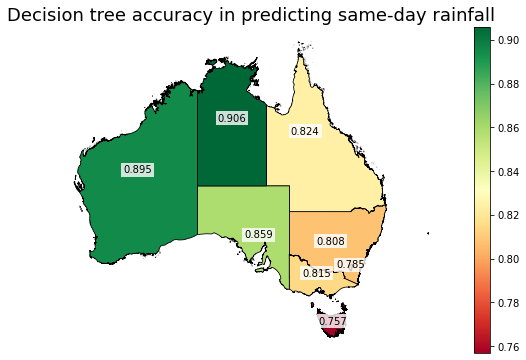

In [25]:
# set up the today map figure
fig, ax = plt.subplots(1, figsize=(10, 6));

# set the title
ax.set_title("Decision tree accuracy in predicting same-day rainfall", fontdict={"fontsize": "18", 
                                                                     "fontweight": "3"})

# plot the accuracy column
Australia.plot(column="Today Accuracy", linewidth=0.8, ax=ax, edgecolor='0', cmap='RdYlGn');

# loop through the geodataframe
for idx, row in Australia.iterrows():
    
    # annotate the states with their scores
    ax.text(row.coords[0], row.coords[1], 
            s=row["Today Accuracy"], 
            horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

# set up the color bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(today_accuracy_list), 
                                                             vmax=max(today_accuracy_list)))

# make an empty array for the data range
sm._A = []

# plot the bar
bar = fig.colorbar(sm)

# remove axes from map
ax.axis('off')

plt.savefig(source_directory + "/Figures/Same-day_accuracy.png", dpi=300, transparent = False)

Now we can compare the same-day and next-day results.

In [31]:
Australia.head()

STE_CODE16         STE_NAME16    AREASQKM16  \
0          1    New South Wales  8.008108e+05   
1          2           Victoria  2.274956e+05   
2          3         Queensland  1.730172e+06   
3          4    South Australia  9.842749e+05   
4          5  Western Australia  2.526646e+06   

                                            geometry  Tomorrow Accuracy  \
0  MULTIPOLYGON (((149.91634 -37.07401, 149.91624...              0.817   
1  MULTIPOLYGON (((144.73141 -38.35025, 144.73147...              0.827   
2  MULTIPOLYGON (((152.93630 -25.74359, 152.93631...              0.836   
3  MULTIPOLYGON (((140.13106 -37.58957, 140.13100...              0.849   
4  MULTIPOLYGON (((117.95914 -35.09446, 117.95910...              0.895   

                                     coords  Today Accuracy  
0  (146.34593103271916, -32.83104951149994)           0.808  
1  (144.54966913395063, -36.55857162849995)           0.815  
2  (143.0497258291639, -19.934063009499937)           0.824  
3  (136.9483345954614, -32.028824594999946)           0.859  
4  (121.20214217889564, -24.43881599699995)           0.895

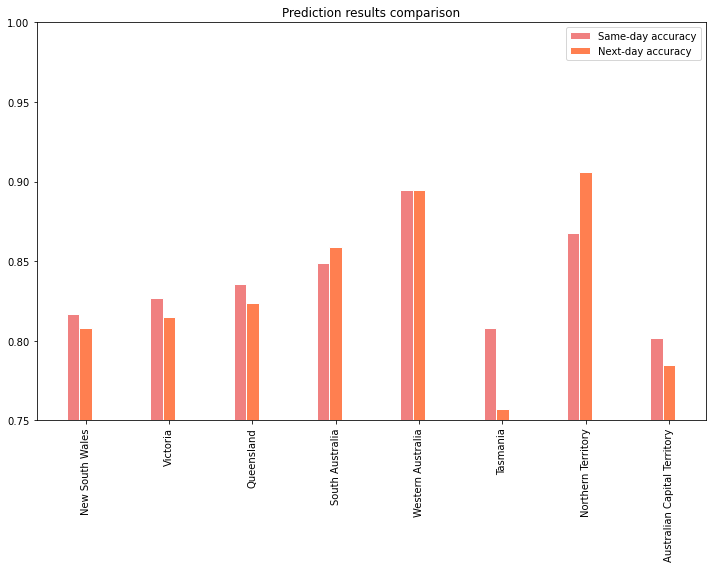

In [36]:
# set general figure parameters
fig = plt.figure(figsize=(10, 8), tight_layout=True)

# set the title
plt.title("Prediction results comparison")

# set the width of each bar
barWidth = 0.15

# set the x-axis labels
states = list(Australia["STE_NAME16"])

# get the heights of all the bars from the dictionary results, add the proccesing time          
today_bar = Australia["Tomorrow Accuracy"]
tomorrow_bar = Australia["Today Accuracy"]

# set position of each bar on the X axis
bar_x1 = np.arange(len(today_bar))
bar_x2 = [x + barWidth for x in bar_x1]

# plot each bar
plt.bar(bar_x1, today_bar, color='lightcoral', width=barWidth, edgecolor='white', label='Same-day accuracy')
plt.bar(bar_x2, tomorrow_bar, color='coral', width=barWidth, edgecolor='white', label='Next-day accuracy')

# # set the x-axis spacing and labels
plt.ylim(0.75, 1.0)
plt.xticks([r + barWidth for r in range(len(today_bar))], states)
plt.xticks(rotation=90)

# show the legend and figure, save
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(source_directory + "/Figures/Compare_accuracy.png", dpi=300, transparent = False)